# MFCC

In [ ]:
import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt
import json
import os
import math

from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

import matplotlib.pyplot as plt

In [ ]:
DATASET_PATH = "sound - robot"
JSON_PATH = "model_robot/data_sound.json"
SAMPLE_RATE = 16000
TRACK_DURATION = 1 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

In [ ]:
train_audio_path = r'G:\Python\Lenh_dieu_khien\sound - robot'
labels=os.listdir(train_audio_path)

In [ ]:
def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512):
    """Extracts MFCCs from music dataset and saves them into a json file along with genre labels.
        """

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        if dirpath is not dataset_path:

            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            for f in filenames:
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                mfcc = librosa.feature.mfcc(signal, sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                mfcc = mfcc.T

                if len(mfcc) == num_mfcc_vectors_per_segment:
                    data["mfcc"].append(mfcc.tolist())
                    data["labels"].append(i-1)
                    print("{}".format(file_path))

    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

In [ ]:
save_mfcc(DATASET_PATH, JSON_PATH)

# Data Load

In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

In [ ]:
DATA_PATH = "model_robot/data_sound.json"

In [ ]:
def load_data(data_path):

    with open(data_path, "r") as f:
        data = json.load(f)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")

    return  X, y

# Conv2D

In [ ]:
X, y = load_data(DATA_PATH)

In [ ]:
# create train, validation and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

# add an axis to input sets
X_train = X_train[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)

In [320]:
# build the CNN
model_cnn = keras.Sequential()

model_cnn.add(keras.layers.Conv2D(4, (2, 2), activation='relu', input_shape=input_shape))
model_cnn.add(keras.layers.Conv2D(4, (3, 3), activation='relu'))
model_cnn.add(keras.layers.Flatten())

model_cnn.add(keras.layers.Dense(16, activation='relu'))
model_cnn.add(keras.layers.Dropout(0.3))

model_cnn.add(keras.layers.Dense(4, activation='softmax'))

In [321]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model_cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [322]:
model_cnn.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 31, 12, 4)         20        
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 29, 10, 4)         148       
_________________________________________________________________
flatten_24 (Flatten)         (None, 1160)              0         
_________________________________________________________________
dense_48 (Dense)             (None, 16)                18576     
_________________________________________________________________
dropout_24 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 4)                 68        
Total params: 18,812
Trainable params: 18,812
Non-trainable params: 0
_________________________________________________

In [323]:
# train model
history = model_cnn.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=50)

Epoch 1/50
8/8 [==============================] - 0s 25ms/step - loss: 12.7397 - accuracy: 0.3042 - val_loss: 11.0146 - val_accuracy: 0.2344
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 9.1592 - accuracy: 0.2627 - val_loss: 8.3709 - val_accuracy: 0.2188
Epoch 3/50
8/8 [==============================] - 0s 8ms/step - loss: 7.0157 - accuracy: 0.2836 - val_loss: 6.2949 - val_accuracy: 0.2500
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 7.3119 - accuracy: 0.3144 - val_loss: 4.9414 - val_accuracy: 0.2656
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 6.1500 - accuracy: 0.2782 - val_loss: 4.0299 - val_accuracy: 0.2812
Epoch 6/50
8/8 [==============================] - 0s 8ms/step - loss: 5.2295 - accuracy: 0.2912 - val_loss: 3.5499 - val_accuracy: 0.2969
Epoch 7/50
8/8 [==============================] - 0s 8ms/step - loss: 4.2471 - accuracy: 0.3108 - val_loss: 3.1779 - val_accuracy: 0.3281
Epoch 8/50
8/8 [===============

In [324]:
def plot_history(history):

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    
    plt.savefig('plot.png')
    plt.show()

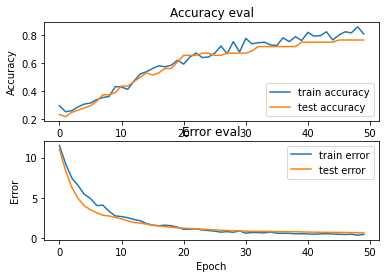

In [325]:
# plot accuracy and error as a function of the epochs
plot_history(history)

In [326]:
# evaluate model on Test Set
test_loss, test_acc = model_cnn.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

3/3 - 0s - loss: 0.4105 - accuracy: 0.9000

Test accuracy: 0.8999999761581421


In [327]:
yhat_classes = model_cnn.predict_classes(X_test, verbose=0)

In [328]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [329]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes, average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes, average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes, average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.900000
Precision: 0.901064
Recall: 0.900000
F1 score: 0.899940


In [330]:
model_cnn.save("model_sum/MFCC_CNN.h5")